# <font style="color:blue">LR Scheduler</font>

We know that decreasing the learning rate with epochs or after a few epochs does help in convergence. Thankfully, this can be done in PyTorch using the `torch.optim.lr_scheduler` class which changes the learning rate for the optimizer depending upon the type of scheduler chosen. 

In this notebook, we will see how to use different learning rate schedulers. 

We will use the "Fashion MNIST" dataset, and SGD optimizer with momentum to illustrate the convergence of different learning rate schedulers.

We will use the same LeNet architecture.

In [14]:
%matplotlib inline

In [15]:
import matplotlib.pyplot as plt  # one of the best graphics library for python
plt.style.use('ggplot')

In [16]:
import os
import time

from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

# <font style="color:blue">1. LeNet Architecture</font>

In [17]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=120, out_features=84), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

# <font style="color:blue">2. Display the Network</font>

In [18]:
lenet_model = LeNet()
print(lenet_model)

LeNet(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


# <font style="color:blue">3. Get Fashion MNIST Data</font>

In [19]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scales image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.2860) and divide by variance (0.3530).
        # This mean and variance is calculated on training data (verify for yourself)
        transforms.Normalize((0.2860, ), (0.3530, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

# <font style="color:blue">4. System Configuration</font>

In [20]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

# <font style="color:blue">5. Training Configuration</font>

In [21]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 50  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 500  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "./data"  # folder to save Fashion MNIST data (default: data)
    num_workers: int = 10  # number of concurrent processes used to prepare data
    device: str = 'cuda'  # device to use for training.
    


# <font style="color:blue">6. System Setup</font>

In [22]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# <font style="color:blue">7. Training</font>
We are familiar with the training pipeline used in PyTorch.

In [23]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mode
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (it is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

#         if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
#             print(
#                 'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
#                     epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
#                 )
#             )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    
    print('\nEpoch: {} Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))

    return epoch_loss, epoch_acc

# <font style="color:blue">8. Validation</font>

In [24]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

# <font style="color:blue">9. Main</font>

Most of the code in this section is similar to what you have already seen in previous sections. The only change is that when we use the `ReduceLROnPlateau` Scheduler, we use the train_loss as a metric to monitor and reduce the learning rate.


In [25]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        
        # scheduler step/ update learning rate
        if scheduler is not None:
            if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_loss)
                print("Bad Epochs:{}".format(scheduler.num_bad_epochs))
                print("last LR = {}".format(scheduler._last_lr))
            else:
                scheduler.step()
            
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

# <font style="color:blue">10. Training using SGD Momentum without LR Scheduler</font>

```
torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
```

The default value of momentum is `0`, we should change it to `0.9`.

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [26]:
model = LeNet()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=train_config.learning_rate,
    momentum = 0.9
)


model, train_loss_sgd_momentum, train_acc_sgd_momentum, test_loss_sgd_momentum, test_acc_sgd_momentum = main(
    model, 
    optimizer)




Epoch: 0 Loss: 0.580646 Acc: 0.7827
Elapsed 10.05s, 10.05 s/epoch, 0.01 s/batch, ets 492.58s

Epoch: 1 Loss: 0.342900 Acc: 0.8724
Elapsed 20.03s, 10.02 s/epoch, 0.01 s/batch, ets 480.73s

Epoch: 2 Loss: 0.303934 Acc: 0.8870
Elapsed 30.20s, 10.07 s/epoch, 0.01 s/batch, ets 473.15s

Epoch: 3 Loss: 0.281451 Acc: 0.8931
Elapsed 40.25s, 10.06 s/epoch, 0.01 s/batch, ets 462.82s

Epoch: 4 Loss: 0.264629 Acc: 0.9010
Elapsed 50.17s, 10.03 s/epoch, 0.01 s/batch, ets 451.54s

Epoch: 5 Loss: 0.250988 Acc: 0.9055
Elapsed 59.59s, 9.93 s/epoch, 0.01 s/batch, ets 436.97s

Epoch: 6 Loss: 0.235699 Acc: 0.9108
Elapsed 68.89s, 9.84 s/epoch, 0.01 s/batch, ets 423.19s

Epoch: 7 Loss: 0.227318 Acc: 0.9150
Elapsed 78.66s, 9.83 s/epoch, 0.01 s/batch, ets 412.98s

Epoch: 8 Loss: 0.215252 Acc: 0.9192
Elapsed 88.45s, 9.83 s/epoch, 0.01 s/batch, ets 402.94s

Epoch: 9 Loss: 0.206555 Acc: 0.9230
Elapsed 98.46s, 9.85 s/epoch, 0.01 s/batch, ets 393.84s

Epoch: 10 Loss: 0.201196 Acc: 0.9235
Elapsed 107.65s, 9.79 s/epo

# <font style="color:blue">11. Training with Learning Rate Scheduler</font>


## <font style="color:green">11.1. Time Based (MultiplicativeLR)</font>

$$
\alpha = \frac{\alpha_0}{1 + \gamma n} 
$$

where, $\alpha_0 = \text{inital learning rate} $

$\gamma = \text{decay_rate}$

$n = \text{epoch}$

**MultiplicativeLR method in PyTorch:**

```
torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda, last_epoch=-1)
```

- `optimizer` (Optimizer) – Wrapped optimizer.

- `lr_lambda` (function or list) – A function which computes a multiplicative factor given an integer parameter epoch, or a list of such functions, one for each group in optimizer.param_groups.

- `last_epoch` (python:int) – The index of last epoch. Default: -1.

Details find [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.MultiplicativeLR).


In [27]:
model = LeNet()

init_learning_rate = 0.02

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr = init_learning_rate,
    momentum = 0.9
)

decay_rate = 0.5
lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)


model, train_loss_time_based, train_acc_time_based, test_loss_time_based, test_acc_time_based = main(
    model, 
    optimizer, 
    scheduler)




Epoch: 0 Loss: 0.554709 Acc: 0.7949
Elapsed 10.19s, 10.19 s/epoch, 0.01 s/batch, ets 499.21s

Epoch: 1 Loss: 0.333650 Acc: 0.8773
Elapsed 20.21s, 10.11 s/epoch, 0.01 s/batch, ets 485.14s

Epoch: 2 Loss: 0.287620 Acc: 0.8921
Elapsed 30.27s, 10.09 s/epoch, 0.01 s/batch, ets 474.20s

Epoch: 3 Loss: 0.259736 Acc: 0.9027
Elapsed 40.38s, 10.10 s/epoch, 0.01 s/batch, ets 464.43s

Epoch: 4 Loss: 0.237584 Acc: 0.9101
Elapsed 50.83s, 10.17 s/epoch, 0.01 s/batch, ets 457.44s

Epoch: 5 Loss: 0.222403 Acc: 0.9145
Elapsed 61.08s, 10.18 s/epoch, 0.01 s/batch, ets 447.89s

Epoch: 6 Loss: 0.207147 Acc: 0.9210
Elapsed 71.22s, 10.17 s/epoch, 0.01 s/batch, ets 437.52s

Epoch: 7 Loss: 0.194089 Acc: 0.9252
Elapsed 81.20s, 10.15 s/epoch, 0.01 s/batch, ets 426.28s

Epoch: 8 Loss: 0.183275 Acc: 0.9297
Elapsed 91.37s, 10.15 s/epoch, 0.01 s/batch, ets 416.23s

Epoch: 9 Loss: 0.173245 Acc: 0.9341
Elapsed 101.47s, 10.15 s/epoch, 0.01 s/batch, ets 405.88s

Epoch: 10 Loss: 0.164875 Acc: 0.9372
Elapsed 111.75s, 10.1

## <font style="color:green">11.2. Step Decay (StepLR)</font>

$$
\alpha = \alpha_0 * \gamma^{\lfloor\frac{n}{s}\rfloor}
$$

where, $\alpha_0 = \text{inital learning rate} $

$n = \text{epoch}$

$\gamma = \text{decay_rate}$

$s = \text{step_size}$

**StepLR method:**

```
torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1)
```
- `optimizer` (Optimizer) – Wrapped optimizer.

- `step_size` (python:int) – Period of learning rate decay.

- `gamma` (python:float) – Multiplicative factor of learning rate decay. Default: `0.1`.

- `last_epoch` (python:int) – The index of last epoch. Default: `-1`.

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR).

In [28]:
model = LeNet()

init_learning_rate = 0.02

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr = init_learning_rate,
    momentum = 0.9
)

step_size = 10

decay_rate = 0.5

scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=decay_rate)


model, train_loss_step_decay, train_acc_step_decay, test_loss_step_decay, test_acc_step_decay = main(
    model, 
    optimizer, 
    scheduler)


Epoch: 0 Loss: 0.554709 Acc: 0.7949
Elapsed 10.27s, 10.27 s/epoch, 0.01 s/batch, ets 503.19s

Epoch: 1 Loss: 0.355156 Acc: 0.8701
Elapsed 20.38s, 10.19 s/epoch, 0.01 s/batch, ets 489.07s

Epoch: 2 Loss: 0.320139 Acc: 0.8814
Elapsed 31.17s, 10.39 s/epoch, 0.01 s/batch, ets 488.34s

Epoch: 3 Loss: 0.301080 Acc: 0.8885
Elapsed 41.44s, 10.36 s/epoch, 0.01 s/batch, ets 476.53s

Epoch: 4 Loss: 0.283894 Acc: 0.8945
Elapsed 51.50s, 10.30 s/epoch, 0.01 s/batch, ets 463.50s

Epoch: 5 Loss: 0.276053 Acc: 0.8962
Elapsed 61.70s, 10.28 s/epoch, 0.01 s/batch, ets 452.45s

Epoch: 6 Loss: 0.262769 Acc: 0.9018
Elapsed 71.89s, 10.27 s/epoch, 0.01 s/batch, ets 441.58s

Epoch: 7 Loss: 0.258426 Acc: 0.9035
Elapsed 81.89s, 10.24 s/epoch, 0.01 s/batch, ets 429.92s

Epoch: 8 Loss: 0.247698 Acc: 0.9086
Elapsed 91.67s, 10.19 s/epoch, 0.01 s/batch, ets 417.59s

Epoch: 9 Loss: 0.244374 Acc: 0.9092
Elapsed 101.65s, 10.16 s/epoch, 0.01 s/batch, ets 406.59s

Epoch: 10 Loss: 0.186834 Acc: 0.9288
Elapsed 111.66s, 10.1

## <font style="color:green">11.3. Exponential Decay (ExponentialLR)</font>

$$
\alpha = \alpha_0 * \gamma^n
$$

where, $\alpha_0 = \text{inital learning rate} $

$n = \text{epoch}$

$\gamma = \text{decay_rate}$

**ExponentialLR method:**

```
torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)
```
- `optimizer` (Optimizer) – Wrapped optimizer.

- `gamma` (python:float) – Multiplicative factor of learning rate decay.

- `last_epoch` (python:int) – The index of last epoch. Default: -1.

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ExponentialLR).

In [29]:
model = LeNet()

init_learning_rate = 0.02

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr = init_learning_rate,
    momentum = 0.9
)


decay_rate = 0.9

scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)


model, train_loss_exp_decay, train_acc_exp_decay, test_loss_exp_decay, test_acc_exp_decay = main(
    model, 
    optimizer, 
    scheduler)


Epoch: 0 Loss: 0.554709 Acc: 0.7949
Elapsed 9.70s, 9.70 s/epoch, 0.01 s/batch, ets 475.18s

Epoch: 1 Loss: 0.350476 Acc: 0.8709
Elapsed 19.67s, 9.83 s/epoch, 0.01 s/batch, ets 472.07s

Epoch: 2 Loss: 0.306980 Acc: 0.8868
Elapsed 29.94s, 9.98 s/epoch, 0.01 s/batch, ets 469.12s

Epoch: 3 Loss: 0.280417 Acc: 0.8962
Elapsed 39.57s, 9.89 s/epoch, 0.01 s/batch, ets 455.05s

Epoch: 4 Loss: 0.256035 Acc: 0.9038
Elapsed 48.94s, 9.79 s/epoch, 0.01 s/batch, ets 440.50s

Epoch: 5 Loss: 0.238071 Acc: 0.9092
Elapsed 58.49s, 9.75 s/epoch, 0.01 s/batch, ets 428.91s

Epoch: 6 Loss: 0.222914 Acc: 0.9146
Elapsed 68.04s, 9.72 s/epoch, 0.01 s/batch, ets 417.97s

Epoch: 7 Loss: 0.206707 Acc: 0.9202
Elapsed 77.70s, 9.71 s/epoch, 0.01 s/batch, ets 407.91s

Epoch: 8 Loss: 0.191910 Acc: 0.9252
Elapsed 87.43s, 9.71 s/epoch, 0.01 s/batch, ets 398.28s

Epoch: 9 Loss: 0.177952 Acc: 0.9313
Elapsed 97.21s, 9.72 s/epoch, 0.01 s/batch, ets 388.83s

Epoch: 10 Loss: 0.166021 Acc: 0.9345
Elapsed 107.18s, 9.74 s/epoch, 0.

## <font style="color:green">11.4. ReduceLROnPlateau</font>

This is the most interesting scheduler. In all the above LR-schedulers, reducing strategy is already defined. So it is a matter of experience and experiments to find the right hyperparameters of LR-scheduler. `ReduceLROnPlateeau` does solve this problem.

For the given number of epochs, if the model does not improve, it reduces the learning rate.

**ReduceLROnPlateau method:**

```
torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
```
- `optimizer` (Optimizer) – Wrapped optimizer.

- `mode` (str) – One of min, max. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; in max mode it will be reduced when the quantity monitored has stopped increasing. Default: ‘min’.

- `factor` (python:float) – Factor by which the learning rate will be reduced. `new_lr = lr * factor`. Default: `0.1`.

- `patience` (python:int) – Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: `10`.

- `verbose` (bool) – If True, prints a message to stdout for each update. Default: False.

- `threshold` (python:float) – Threshold for measuring the new optimum, to only focus on significant changes. Default: `1e-4`.

- `threshold_mode` (str) – One of rel, abs. In rel mode, dynamic_threshold = best * ( 1 + threshold ) in ‘max’ mode or best * ( 1 - threshold ) in min mode. In abs mode, dynamic_threshold = best + threshold in max mode or best - threshold in min mode. Default: ‘rel’.

- `cooldown` (python:int) – Number of epochs to wait before resuming normal operation after lr has been reduced. Default: `0`.

- `min_lr` (python:float or list) – A scalar or a list of scalars. A lower bound on the learning rate of all param groups or each group respectively. Default: `0`.

- `eps` (python:float) – Minimal decay applied to lr. If the difference between new and old lr is smaller than eps, the update is ignored. Default: 1e-8.

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau)


We have configured the scheduler as follows:
1. We will use `train_loss` as a metric to watch if it stagnates.
1. We keep `threshold` to `0.1`. So, we will watch out for change in the first decimal, i.e. redule LR if the change consecutive epochs have difference of 0.1.
1. We will keep `patience` at `5` epochs which means we will wait for 5 epochs before changing the learning rate.

In [30]:
model = LeNet()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=train_config.learning_rate,
    momentum = 0.9
)

factor = 0.3  # reduce by factor 0.5
patience = 2  # epochs
threshold = 0.1
verbose = True

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience, verbose=verbose, threshold=threshold)


model, train_loss_plateau, train_acc_plateau, test_loss_plateau, test_acc_plateau = main(
    model, 
    optimizer, 
    scheduler)

C:\Program Files\Python310\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Epoch: 0 Loss: 0.590753 Acc: 0.7813
Elapsed 9.95s, 9.95 s/epoch, 0.01 s/batch, ets 487.59s
Bad Epochs:0
last LR = [0.01]

Epoch: 1 Loss: 0.360213 Acc: 0.8660
Elapsed 19.78s, 9.89 s/epoch, 0.01 s/batch, ets 474.74s
Bad Epochs:0
last LR = [0.01]

Epoch: 2 Loss: 0.316631 Acc: 0.8835
Elapsed 29.72s, 9.91 s/epoch, 0.01 s/batch, ets 465.61s
Bad Epochs:0
last LR = [0.01]

Epoch: 3 Loss: 0.291827 Acc: 0.8912
Elapsed 39.65s, 9.91 s/epoch, 0.01 s/batch, ets 455.94s
Bad Epochs:1
last LR = [0.01]

Epoch: 4 Loss: 0.270988 Acc: 0.8991
Elapsed 49.52s, 9.90 s/epoch, 0.01 s/batch, ets 445.66s
Bad Epochs:0
last LR = [0.01]

Epoch: 5 Loss: 0.254599 Acc: 0.9031
Elapsed 59.42s, 9.90 s/epoch, 0.01 s/batch, ets 435.76s
Bad Epochs:1
last LR = [0.01]

Epoch: 6 Loss: 0.241804 Acc: 0.9089
Elapsed 69.33s, 9.90 s/epoch, 0.01 s/batch, ets 425.87s
Bad Epochs:0
last LR = [0.01]

Epoch: 7 Loss: 0.229695 Acc: 0.9137
Elapsed 79.40s, 9.93 s/epoch, 0.01 s/batch, ets 416.85s
Bad Epochs:1
last LR = [0.01]

Epoch: 8 Loss: 0

# <font style="color:blue">12. Loss Plot</font>

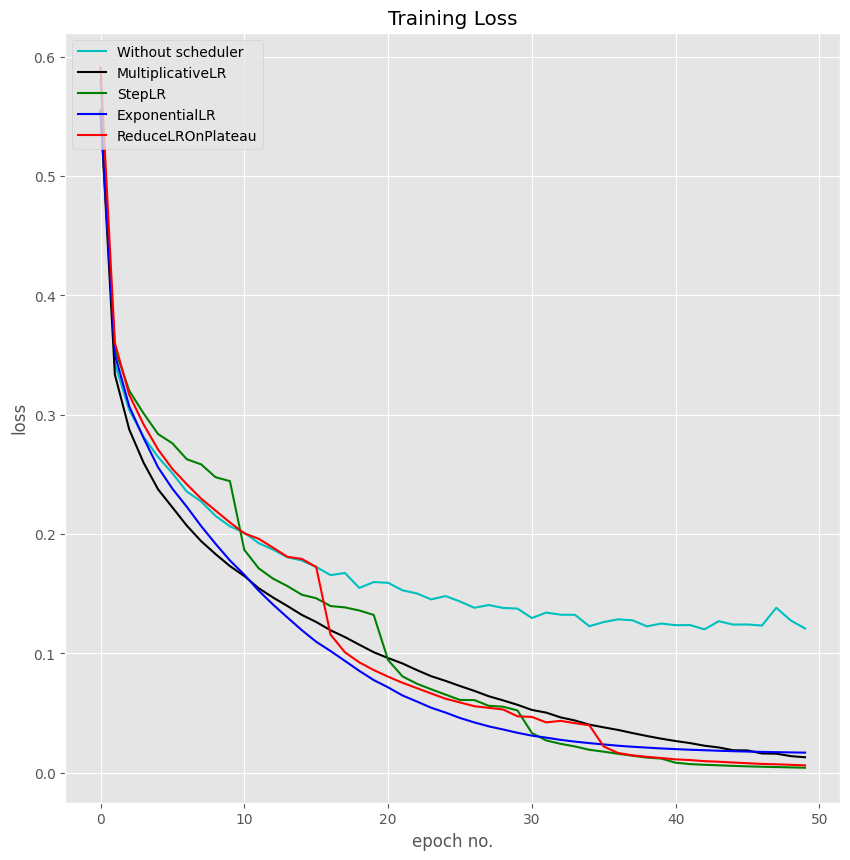

In [31]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 10)
x = range(len(train_loss_sgd_momentum))

plt.figure


plt.plot(x, train_loss_sgd_momentum, 'c', label="Without scheduler")

plt.plot(x, train_loss_time_based, 'k', label="MultiplicativeLR")

plt.plot(x, train_loss_step_decay, 'g', label="StepLR")

plt.plot(x, train_loss_exp_decay, 'b', label="ExponentialLR")

plt.plot(x, train_loss_plateau, 'r', label="ReduceLROnPlateau")

plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.title('Training Loss')
plt.show()

# <font style="color:blue">Conclusion</font>
We saw the various LR Schedulers in action, but practically there is no one-size-fits-all LR Scheduler which works for any problem. Ideally you should run multiple experiments with different LR schedulers to find the best model. 

For example, when you are solving a new problem, you won't know what is the actual loss which gives best results or what is the best loss you can get with your model and data. So, you can run some experiments using StepLR/others and you might see that the loss has decreased substantially (say the loss is varying around 0.035 to 0.038. However, you feel it can decrease further. So, try with the ReduceLROnPlateau Scheduler with a threshold that you feel might be right after doing the previous experiment (say 0.005) which means that if it stays in 0.35 to 0.38 range, you should decrease the LR.